In [1]:
%config Completer.use_jedi = False

In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

In [3]:
import gym
from gym.spaces import MultiDiscrete

In [4]:
from copy import copy, deepcopy

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

/home/victorialena/anaconda3/envs/rlpyt/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping
/home/victorialena/anaconda3/envs/rlpyt/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sized


In [6]:
def get_random_queues(n: int, beta: float = 0.8):
    free = [True]*n
    out = []
    for i in np.random.permutation(n):
        if not free[i]:
            continue
        free[i] = False
        
        while np.random.rand() < beta:
            try:
                j = np.random.choice(np.where(free)[0])
            except:
                return out
            free[j] = False
            out.append([i, j])
            i = j
    return out

def count_q_length(_from, _to, n):
    counts, prev_counts = torch.zeros(n), torch.zeros(n)
    counts[_from] = 1
    while not all(counts == prev_counts):
        prev_counts = deepcopy(counts)
        counts[_from] = counts[_to]+1
    return counts

```python
g.nodes('job')
g.ntypes
g.etypes
g.canonical_etypes
```

### Environment

In [7]:
class jobShopScheduling(gym.Env):
    """
    ### Description
    Learning to schedule a successful sequence of “job” to multiple workers respecting given constraints. 
    
    ### Action Space
    By adding an edge from a worker to an unscheduled job, the job gets queued to that thread.
    The resulting sequence can not be chnaged in hindsight.
    
    ### State Space    
    A disjunctive heterogeneous graph g = (V, C U D). Each node represents a “job” or a “worker”. 
    Edges in C denote succession requirements for jobs, edges in D denotes which jobs were assigned to 
    which worker. 
    
    ### Rewards
    The system recieves a positive unit reward for each executed job. And a penalty per time step.
    
    ### Starting State
    A random set of n jobs, including time requirements and succession constraints, e.g., task i requires 
    completion of task j.
    
    ### Episode Termination
    The episode terminates when all jobs have been scheduled. Then the action space has schunken to size 0.
    The final reward tallies up the remaining rewards to be versed (w/o time discounting).
    
    ### Arguments
    No additional arguments are currently supported.
    
    ### Baselines
    1) C* -> optimal makespan [https://developers.google.com/optimization/scheduling/job_shop]
    2) Heuristics -> Use same as Prof. Park's paper
    3) Other: Simualted Annealing
    
    ### Comments
    https://medium.datadriveninvestor.com/job-shop-scheduling-problem-jssp-an-overview-cd99970a02f8
    """

    def __init__(self, njobs: int, nworkers: int):
        self._njobs = njobs
        self._nworkers = nworkers
        self._jfeat = 7
        self._wfeat = 3
        self._dt = 0.1
        self._time_penalty = -0.01
        
        self._state = None
        
    def reward(self, a):
        assert False, "Not implemented. Do not call."
    
    def terminal(self):
        # Terminal state is reached when all the jobs have been scheduled. |A| is zero.
        return all(self._state.nodes['job'].data['hv'][:, 3] == 1)
    
    def worker_features(self):
        return ('n queued', 'expected run time', 'efficiency rate')
    
    def job_features(self):
        return ('time req', 
                'completion%', #1
                'nr of child nodes', #2 
                'status (one hot: scheduled, processing, finished)', #3-4-5
                'remaining time') #6
    
    def valid_action(self, a):
        _, j = a
        return self._state.nodes['job'].data['hv'][j, 3] == 0
    
    def check_job_requirements(self, j):
        # Return True if no incoming edges from preceding job requirements.
        _, dst = self._state.edges(etype='precede')
        return all(dst != j)
    
    def rollout(self, verbose=False):
        # Return number of jobs complete if we just waited until all workers exit (done of gridlock)
        # Does not take into account discount factor!
        state_hv = deepcopy(self._state.nodes['job'].data['hv'])
        state_he = deepcopy(self._state.nodes['worker'].data['he'])
        
        jdone = state_hv[:, 5] == 1
        
        reward = torch.tensor([0.])
        src, dst = deepcopy(self._state.edges(etype='processing'))
        sreq, dreq = deepcopy(self._state.edges(etype='precede'))
        
        while True:
            idx = [dst[src==w][0].item() for w in src.unique().tolist()]
            idx = [j for j in idx if all(jdone[sreq[dreq==j]])]
            if len(idx) == 0:
                break # gridlock
            
            # get smallest remaining time for idx. -(.dt)
            j = idx[state_hv[idx, 6].argmin().item()]
            if verbose:
                print("executing job", j, "on worker", src[dst==j].item())
            jdone[j] = True
            reward += 1. + state_hv[j, 6].div(self._dt, rounding_mode='trunc')*self._time_penalty
            state_hv[idx, 6] -= state_hv[j, 6] #mark that job as done
            
            # remove job from queue
            src = src[dst!=j]
            dst = dst[dst!=j]
            
        # clean up graph
        idx = np.where(jdone)[0]
        
        src, dst, cnts = self._state.edges('all', etype='processing')
        jidx = [(j in idx) for j in dst]
        self._state.remove_edges(cnts[jidx].tolist(), 'processing')                
        
        for etype in ['next', 'precede']:
            src, dst, cnts = self._state.edges('all', etype=etype)
            jidx = [(j in idx) for j in src]
            self._state.remove_edges(cnts[jidx].tolist(), etype)
            
        self._state.nodes['job'].data['hv'][idx, 2] = 1.
        self._state.nodes['job'].data['hv'][idx, 4] = 0.
        self._state.nodes['job'].data['hv'][idx, 5] = 1. # mark terminal
        self._state.nodes['job'].data['hv'][idx, 6] = 0. # set remaining time to 0
        
        src, _ = self._state.edges(etype='processing')
        if len(src):
            w, cnts = src.unique(return_counts=True)
            self._state.nodes['worker'].data['he'][w, 0] = cnts.float()

        return reward.item(), all(jdone)
    
    def get_node_status(self, label, by_index=True):
        mask = self._state.nodes['job'].data['hv'][:, label] == 1
        if by_index:
            return np.where(mask)[0].tolist()
        return mask
        
    def get_scheduled(self, by_index=True):
        return self.get_node_status(3, by_index)
    
    def get_unscheduled(self, by_index=True):
        mask = ~self.get_node_status(3, False)
        if by_index:
            return np.where(mask)[0].tolist()
        return mask
    
    def get_processing(self, by_index=True):
        return self.get_node_status(4, by_index)
    
    def get_terminated(self, by_index=True):
        return self.get_node_status(5, by_index)
    
    def is_gridlocked(self):
        if len(self.get_processing()):
            return False

        src, dst = self._state.edges(etype='processing')
        if len(src.unique()) != self._nworkers:
            return False

        _, req = self._state.edges(etype='precede')
        newidx = [dst[src==w][0].item() for w in src.unique().tolist()]
        newidx = [j for j in newidx if j not in req]
        return len(newidx)>0
    
    def step(self, a):
        assert self.valid_action(a), "Invalid action taken: (w:%d, j:%d)" % a
        
        src, dst, cnts = self._state.edges('all', etype='processing')
        
        """ 
        1) Schedule job j for worker w: 
            a) Find last job scheduled for worker w, add edge from end of queue to new job j. 
            b) Add edge from w to j. 
            c) Update worker info (queue length, run time estimate).
            d) Mark job as scheduled.
        """
        w, j = a
        if w in src:
            _i = dst[src==w][-1].item() # add to end of q -- last edge added
            self._state.add_edge(_i, j, etype='next')        
        self._state.add_edge(w, j, etype='processing')
        
        state_hv = deepcopy(self._state.nodes['job'].data['hv'])
        state_he = deepcopy(self._state.nodes['worker'].data['he'])
        
        state_he[w, 0] += 1. # add job to work queue length
        state_he[w, 1] += state_hv[j, 0] # update worker' run time estimate
        state_hv[j, 3] = 1. # mark as scheduled
                
        """ 2) Assure the first job in queue is being processed at this time step. """
        _, req = self._state.edges(etype='precede')
        # src, dst, cnts = self._state.edges('all', etype='processing') # call again to update processing
        newidx = [dst[src==w][0].item() for w in src.unique().tolist()]
        newidx = [j for j in newidx if j not in req]
        state_hv[newidx, 4] = 1 # set to processing (but completion % remain 0)
        
        # write info incase of early exit
        self._state.nodes['job'].data['hv'] = state_hv
        self._state.nodes['worker'].data['he'] = state_he

        """ 
        3) Update feature vectors:
            a) Progress time for node features: remaining time, completion % for jobs and workers
            b) Update info around terminal jobs, and remove processing edge if job has terminated.
            c) Remove next and precede edges for terminated jobs. 
        """
        # a
        processing_mask = state_hv[:, 4] == 1        
        if processing_mask.sum() == 0:
            return deepcopy(self._state), self._time_penalty, self.terminal(), {'success':False}
        
        state_hv[processing_mask, 6] = torch.maximum(state_hv[processing_mask, 6]-self._dt,
                                                     torch.zeros(processing_mask.sum())).round(decimals=2) # update remaining time
        state_hv[processing_mask, 1] = torch.clamp(1-torch.div(state_hv[processing_mask, 6],
                                                               state_hv[processing_mask, 0]), 
                                                   min=0, max=1) # update completion %
        
        state_he[:, 1] = torch.maximum(state_he[:, 1]-self._dt, torch.zeros(self._nworkers)) # update remaining time
        
        # b
        state_hv[processing_mask, 5] = (state_hv[processing_mask, 1] == 1).float() # mark terminal
        state_hv[processing_mask, 4] = 1-state_hv[processing_mask, 5] # if terminal, job no longer processing        
        idx = torch.where(processing_mask)[0][torch.where(state_hv[processing_mask, 5])[0]].tolist() # job ids just terminated
        if len(idx):
            widx = [(j in idx) for j in dst]
            state_he[src[widx], 0] -= 1 # remove job from job count
            self._state.remove_edges(cnts[widx].tolist(), 'processing') # delete those edges?
        
            # c
            src, dst, cnts = self._state.edges('all', etype='next')
            ptridx = torch.tensor([cnts[src == j].item() for j in idx if j in src]) # this works because it is a queue: unique next node
            if len(ptridx):
                self._state.remove_edges(ptridx.tolist(), 'next')

            src, dst, cnts = self._state.edges('all', etype='precede')
            jidx = [(j in idx) for j in src]
            if len(jidx):
                self._state.remove_edges(cnts[jidx].tolist(), 'precede') # delete those edges?
                
        """ 5) Update feature vectors. """
        self._state.nodes['job'].data['hv'] = state_hv
        self._state.nodes['worker'].data['he'] = state_he
                
        """ 6) Compute reward and terminal state. """
        done = self.terminal()
        success = False
        n_terminal = len(idx)
        reward = self._time_penalty + n_terminal
        
        if done:
            r, success = self.rollout()
            reward += r
        
        return deepcopy(self._state), deepcopy(reward), deepcopy(done), {'success':success}

    def reset(self, seed: int = None, topology: str = 'random'):
        if not seed == None:
            super().reset(seed=seed)
        
        nw, nj = self._nworkers, self._njobs
        _from, _to = torch.tensor([[0, 0]]+get_random_queues(nj)).T
        
        graph_data = {
           ('job', 'precede', 'job'): (_from, _to), # A ---before---> B
           ('job', 'next', 'job'): (torch.tensor([0]), torch.tensor([0])), # jobshop queue
           ('worker', 'processing', 'job'): (torch.tensor([0]), torch.tensor([0])) # nothing is scheduled
        }
        
        self._state = dgl.heterograph(graph_data, num_nodes_dict={'worker': nw, 'job': nj})
        # hack: can not init null vector for edges
        self._state.remove_edges(0, 'processing')
        self._state.remove_edges(0, 'precede')
        self._state.remove_edges(0, 'next')
                
        times = 0.1*torch.randint(1, 10, (nj,1)) # torch.rand(nj,1)
        _from, _to = _from[1:], _to[1:]
        counts = count_q_length(_from, _to, nj).unsqueeze(-1)
        self._state.nodes['job'].data['hv'] = torch.cat((times, torch.zeros(nj, 1), counts, torch.zeros(nj, 3), times), 1)
        self._state.nodes['worker'].data['he'] = torch.cat((torch.zeros(nw,2), torch.ones(nw,1)), 1)
        
        return deepcopy(self._state)
    
    def dump_state_info(self):
        print('scheduled:', env.get_scheduled())
        print('processing:', env.get_processing())
        print('terminated:', env.get_terminated())
        print('job data:')
        print(self._state.nodes['job'].data['hv'])
        print('worker data:')
        print(self._state.nodes['worker'].data['he'])

    def render(self):
        """
        import networkx as nx
        import matplotlib.pyplot as plt
        """
        self.dump_state_info()
        
        G = dgl.to_homogeneous(self._state).to_networkx(edge_attrs=['_TYPE'])
        
        node_color = ['red']*self._njobs+['orange']*self._nworkers
        edge_color = ['red' if e[-1].item() % 2 else 'orange' for e in G.edges(data='_TYPE')]
        nx.draw(G, node_color=node_color, edge_color=edge_color, with_labels=True)
        
    def seed(self, n: int):
        super().reset(seed=seed)

### Agent

In [8]:
import dgl.function as fn
import dgl.nn.pytorch as dglnn

In [9]:
def construct_readout_graph(g, etype):
    """ 
    Returns graph of edges to be evalutated, i.e., draw edges from each worker to each job node.
    If g is a batched graph representation, return edges within each subgraph.
    etype = use .canonical_etypes() 
    """
    
    utype, _, vtype = etype
    nu, nv = g.num_nodes(utype), g.num_nodes(vtype)
    if not is_batched_graph(g):
        src, dst = g.nodes(utype).repeat(nv), g.nodes(vtype).repeat_interleave(nu)
        
        return dgl.heterograph({etype: (src, dst)},
                               num_nodes_dict={utype: nu, vtype: nv})
    # else:
    node_ids = g.ndata['id']
    src = torch.cat([g.nodes(utype)[node_ids[utype]==i].repeat(c)
                     for i, c in zip(*node_ids[vtype].unique(return_counts=True))])
    dst = torch.cat([g.nodes(vtype)[node_ids[vtype]==i].repeat_interleave(c)
                     for i, c in zip(*node_ids[utype].unique(return_counts=True))])
    
    out = dgl.heterograph({etype: (src, dst)}, num_nodes_dict={utype: nu, vtype: nv})
    out.nodes['job'].data['id'] = g.nodes['job'].data['id']
    out.nodes['worker'].data['id'] = g.nodes['worker'].data['id']
    return out

In [10]:
def is_batched_graph(g):
    return len(g.ndata['id'])!=0

def num_subgraphs(g):
    return 1 if not is_batched_graph(g) else len(g.ndata['id']['job'].unique())

def sg_nworkers(g):
    if is_batched_graph(g):
        idx, cnts = g.ndata['id']['worker'].unique(return_counts=True)
        if len(cnts.unique()) == 1:
            return cnts.unique().item()
        return cnts
    return g.num_nodes('worker')

In [11]:
class dotProductPredictor(nn.Module):
    """ returns scores for each job (row) per worker (col)"""
    def forward(self, graph, hv, he, _etype):
        # hv contains the node representations computed from the GNN
        utype, etype, vtype = _etype
        nu = sg_nworkers(graph)
        assert type(nu)==int, "Graphs have different workers counts. Can not proceed this eval without errors."
        with graph.local_scope():
            graph.nodes[vtype].data['hv'] = hv
            graph.nodes[utype].data['he'] = he
            graph.apply_edges(fn.u_dot_v('he', 'hv', 'score'), etype=etype)
            return graph.edges[etype].data['score'].view(num_subgraphs(graph), -1, nu).squeeze()

```python
class agent(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = dotProductPredictor()
    
    def forward(self, g, x, etype):        
        hv = self.sage(g, x)
        he = g.nodes['worker'].data['he']
        rg = construct_readout_graph(g, ('worker', 'processing', 'job'))
        return self.pred(rg, hv, he, ('worker', 'processing', 'job'))
```

```python
from dgl.nn.pytorch.conv import HGTConv
layer = HGTConv(7, head_size=16, num_heads=4, num_ntypes=2, num_etypes=3, dropout=0.1, use_norm=False)
```

```python
env = jobShopScheduling(10, 2)
g = env.reset()
env.render()```

In [12]:
class hgnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embedding = dglnn.HeteroLinear({'job': 7, 'worker':3}, 16)
        self.conv = dglnn.HeteroGraphConv({
            'precede' : dglnn.GraphConv(16, 16),
            'next' : dglnn.GraphConv(16, 16),
            'processing' : dglnn.SAGEConv((16, 16), 16, 'mean')},
            aggregate='sum')
        self.pred = dotProductPredictor()
        
    def forward(self, g):
        h0 = {**g.ndata['hv'], **g.ndata['he']}
        h1 = self.embedding(h0)
        hv = self.conv(g, h1)['job']
        
        rg = construct_readout_graph(g, ('worker', 'processing', 'job'))
        return self.pred(rg, hv, h1['worker'], ('worker', 'processing', 'job'))    

In [13]:
def batch_graphs(batch):
    n = len(batch)
    
    njs = torch.tensor([g.num_nodes('job') for g in batch])
    nws = torch.tensor([g.num_nodes('worker') for g in batch])
    
    def concat_edges(etype, idx, ns):
        return torch.cat([batch[i].edges(etype=etype)[idx]+ns[:i].sum() for i in range(n)])
    
    batched_graph_data = {
        ('job', 'precede', 'job'): (concat_edges('precede', 0, njs), concat_edges('precede', 1, njs)), 
        ('job', 'next', 'job'): (concat_edges('next', 0, njs), concat_edges('next', 1, njs)),
        ('worker', 'processing', 'job'): (concat_edges('processing', 0, nws), concat_edges('processing', 1, njs)),
    }

    state = dgl.heterograph(batched_graph_data, 
                            num_nodes_dict={'worker': nws.sum().item(), 'job': njs.sum().item()})

    state.nodes['job'].data['hv'] = torch.cat([g.nodes['job'].data['hv'] for g in batch])
    state.nodes['worker'].data['he'] = torch.cat([g.nodes['worker'].data['he'] for g in batch])
    state.nodes['job'].data['id'] = torch.arange(n).repeat_interleave(njs)
    state.nodes['worker'].data['id'] = torch.arange(n).repeat_interleave(nws)
    
    return state

### Q learning

In [14]:
import sys
sys.path.append('/home/victorialena/rlkit')

import pdb

In [15]:
from rlkit.policies.base import Policy
from path_collector import MdpPathCollector

In [16]:
scientific_notation =  lambda x:"{:.2e}".format(x)

In [17]:
class epsilonGreedyPolicy(nn.Module, Policy):
    def __init__(self, net, eps=0.1):
        super().__init__()
        self.net = net
        self.eps = np.clip(eps, .0, 1.)

    def __call__(self, g):
        return self.get_action(g)
    
    def get_action(self, g):
        idx = np.where(g.ndata['hv']['job'][:, 3] == 0)[0] # idx: list of unscheduled job ids
        assert len(idx) > 0, "Unecessary query. Empty action space."
        
        if np.random.rand() < self.eps:
            nw = g.num_nodes(ntype='worker')
            return (np.random.randint(nw), np.random.choice(idx))
        
        out = self.net(g)
        val, workers = out[idx].max(1)
        j = val.argmax().item()
        w = workers[j].item()
        return (w, idx[j])
    
    def get_actions(self, g):
        assert is_batched_graph(g), "This is a single graph, call get_action() instead."
        
        n = num_subgraphs(g)
        idx = (g.ndata['hv']['job'][:, 3] == 0).view(n, -1)
        assert sum(idx).item() > 0, "Empty action space!"
        
        scores = self.net(g)
        out = {}
        values, workers = scores.max(-1, keepdims=False)
        for i in range(n):
            j = torch.where(idx[i])[0][values[i, idx[i]].argmax().item()].item()
            out[i] = (workers[i, j].item(), j)
        return out

In [18]:
def sample_episode(env, agent, max_path_length:int=100):
    obs = env.reset()
    
    observations=[]
    actions=[]
    rewards=[]
    next_observations=[]
    terminals=[]
    
    success=False
    
    for _ in range(max_path_length):
        a = agent.get_action(obs)
        nextobs, reward, done, info = env.step(a)
        
        observations.append(obs)
        actions.append(deepcopy(a))
        rewards.append(reward)
        next_observations.append(nextobs)
        terminals.append(done)
        
        obs = nextobs
        success = info['success']
        
        if done: 
            break
            
    return dict(
        observations=observations,
        actions=actions,
        rewards=rewards,
        next_observations=next_observations,
        terminals=terminals,
        success=success,
    )

```python
net = hgnn()
pol = epsilonGreedyPolicy(net, 0.)

paths = [sample_episode(env, pol, 15) for _ in range(10)]
env.render()
```

In [19]:
from collections import namedtuple
from collections import deque

grep = lambda q, x : list(map(q.__getitem__, x))
grepslice = lambda q, x1, x2 : list(itertools.islice(q, x1, x2))
to_batch = lambda q : torch.stack(list(q))
softmax = lambda x : np.exp(x)/sum(np.exp(x))

Sample = namedtuple("Sample", "s a r sp d")

class replayBuffer():
    def __init__(self, max_replay_buffer_size, replace = True, prioritized=False):
        self._max_replay_buffer_size = max_replay_buffer_size        
        self._replace = replace
        self._prioritized = prioritized
        
        self._weights = deque([], max_replay_buffer_size)
        self._samples = deque([], max_replay_buffer_size)            
    
    def add_paths(self, paths):
        for path in paths:
            self.add_path_samples(path)
    
    def add_path_samples(self, path):
        for s, a, r, sp, d, w in zip(path["observations"],
                                     path["actions"],
                                     path["rewards"],
                                     path["next_observations"],
                                     path["terminals"],
                                     path["rewards"]):
            self._samples.appendleft(Sample(s, a, r, sp, d))
            self._weights.appendleft(w)
        
        self.terminate_episode()
        
    def terminate_episode(self):
        pass

    def random_batch(self, batch_size):
        prio = softmax(self._weights) if self._prioritized else None
        indices = np.random.choice(self.get_size(), 
                                   size=batch_size, p=prio, 
                                   replace=self._replace or self._size < batch_size)
        if not self._replace and self._size < batch_size:
            warn('Replace was set to false, but is temporarily set to true \
            because batch size is larger than current size of replay.')
        
        return grep(self._samples, indices)
    
    def get_size(self):
        return len(self._weights)
        
    def num_steps_can_sample(self):
        return self._max_replay_buffer_size - self.get_size()

    def get_diagnostics(self):
        return OrderedDict([
            ('size', self.get_size())
        ])

```python
replay_buffer_cap = 4000 #10000
replay_buffer = replayBuffer(replay_buffer_cap, prioritized=True)

replay_buffer.add_paths(paths)
batch = replay_buffer.random_batch(6)

batched_g = batch_graphs([b.s for b in batch])

qf = hgnn()
out = qf(batched_g)
out.shape
```

In [20]:
def get_scores(g, scores):
    n = scores.shape[0]
    idx = (g.ndata['hv']['job'][:, 3] == 0).view(n, -1)
    
    values, workers = scores.max(-1, keepdims=False)
    return torch.stack([values[i][idx[i]].max() if sum(idx[i]).item()>0 else torch.tensor(0.) for i in range(n)])

```python
node_ids = batched_g.ndata['id']
torch.cat([batched_g.nodes('worker')[node_ids['worker']==i].repeat(c)
           for i, c in zip(*node_ids['job'].unique(return_counts=True))])
torch.cat([batched_g.nodes('job')[node_ids['job']==i].repeat_interleave(c)
           for i, c in zip(*node_ids['worker'].unique(return_counts=True))])
```

```python 
from dgl.dataloading import GraphDataLoader, DataLoader, NeighborSampler

dataloader = dgl.dataloading.GraphDataLoader([b.s for b in batch],
                                             use_ddp=False,
                                             batch_size=2, shuffle=False,
                                             drop_last=True, num_workers=1)

for batched_graph, labels in dataloader:
    train_on(batched_graph, labels)
    
# OR
dgl.batch(batch) 
```

In [21]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [22]:
njobs, nworkers = 5, 2
env = jobShopScheduling(njobs, nworkers)
g0 = env.reset()
g0

Graph(num_nodes={'job': 5, 'worker': 2},
      num_edges={('job', 'next', 'job'): 0, ('job', 'precede', 'job'): 3, ('worker', 'processing', 'job'): 0},
      metagraph=[('job', 'job', 'next'), ('job', 'job', 'precede'), ('worker', 'job', 'processing')])

In [23]:
qf = hgnn()
expl_policy = epsilonGreedyPolicy(qf, .1)

target_qf = hgnn()
eval_policy = epsilonGreedyPolicy(target_qf, 0.)

expl_path_collector = MdpPathCollector(env, expl_policy, rollout_fn=sample_episode, parallelize=False)
eval_path_collector = MdpPathCollector(env, eval_policy, rollout_fn=sample_episode, parallelize=False)

replay_buffer_cap = 2000 #10000
replay_buffer = replayBuffer(replay_buffer_cap, prioritized=True)

```python
path = rollout(env, expl_policy, 2500)
path['terminals'][-1]
env.render()

replay_buffer.add_path(path, env.g)

replay_buffer.random_batch(50)
```

In [24]:
from torch.optim import Adam

In [25]:
optimizer = Adam(qf.parameters(), lr=1e-4, weight_decay=0.01)
qf_criterion = nn.MSELoss()

max_len = njobs+1
n_samples = 128 
n_epoch = 200
n_iter = 64
batch_size = 32
gamma = 1.0

loss = []
avg_r_train = []
avg_r_eval = []
success_rates = []

In [26]:
def mean_reward(paths):
    return torch.tensor([p['rewards'] for p in paths]).sum(1).mean().item()

In [27]:
for i in range(n_epoch):
    qf.train(False)
    paths = expl_path_collector.collect_new_paths(n_samples, max_len, False)
    train_r = mean_reward(paths)
    avg_r_train.append(train_r)
    replay_buffer.add_paths(paths)
    
    paths = eval_path_collector.collect_new_paths(n_samples//4, max_len, False)
    eval_r = mean_reward(paths)
    avg_r_eval.append(eval_r)
    
    success_rate = np.mean([p['success'] for p in paths])
    success_rates.append(success_rate)

    qf.train(True)
    for _ in range(n_iter):
        batch = replay_buffer.random_batch(batch_size)

        rewards = torch.tensor([b.r for b in batch])
        terminals =torch.tensor([b.d for b in batch]).float()
        actions = torch.tensor([b.a for b in batch])
        
        states = batch_graphs([b.s for b in batch])
        next_s = batch_graphs([b.sp for b in batch])        

        out = target_qf(next_s) # shape = (|G|, |J|, |W|)
        target_q_values = get_scores(next_s, out)
        y_target = rewards + (1. - terminals) * gamma * target_q_values 
        
        out = qf(states)
        y_pred = out[torch.arange(batch_size), actions.T[1], actions.T[0]]
        qf_loss = qf_criterion(y_pred, y_target).to(torch.float)

        loss.append(qf_loss.item())
#         avg_r_train.append(rewards.mean().item())

        optimizer.zero_grad()
        qf_loss.backward()
        optimizer.step()

    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    err = 8
    print("epoch", i+1, #"| lr:", scientific_notation(optimizer.param_groups[0]["lr"]) ,
          " -> loss:", round(np.mean(loss[-n_iter:]), err),
          "| rewards: (train)", round(train_r, err), "(test)", round(eval_r, err),
          "| success rate:", round(success_rate, err))

/home/victorialena/anaconda3/envs/rlpyt/lib/python3.7/site-packages/dgl/heterograph.py:354: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  dgl_warning("DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges")


epoch 1  -> loss: 15.10689212 | rewards: (train) 0.25054684 (test) 1.49593735 | success rate: 0.1875
epoch 2  -> loss: 7.64759813 | rewards: (train) 0.22859375 (test) 0.04 | success rate: 0.0
epoch 3  -> loss: 5.31185205 | rewards: (train) 0.1759375 (test) 0.01031251 | success rate: 0.0
epoch 4  -> loss: 2.94169285 | rewards: (train) 0.04750001 (test) -0.05 | success rate: 0.0
epoch 5  -> loss: 2.33805783 | rewards: (train) 0.06124999 (test) 0.0378125 | success rate: 0.0
epoch 6  -> loss: 1.59240168 | rewards: (train) 0.25078127 (test) -0.05 | success rate: 0.0
epoch 7  -> loss: 1.7506359 | rewards: (train) 0.12242186 (test) -0.05 | success rate: 0.0
epoch 8  -> loss: 2.17546178 | rewards: (train) 0.13117187 (test) -0.05 | success rate: 0.0
epoch 9  -> loss: 1.95334206 | rewards: (train) 0.07992189 (test) -0.05 | success rate: 0.0
epoch 10  -> loss: 1.99678652 | rewards: (train) 0.1621875 (test) 0.0390625 | success rate: 0.0
epoch 11  -> loss: 2.42660038 | rewards: (train) 0.12343747 (

epoch 85  -> loss: 0.52485349 | rewards: (train) 1.86374986 (test) 2.25718713 | success rate: 0.28125
epoch 86  -> loss: 0.54865066 | rewards: (train) 1.67164063 (test) 1.91374969 | success rate: 0.1875
epoch 87  -> loss: 0.51204268 | rewards: (train) 1.95718741 (test) 2.10249996 | success rate: 0.25
epoch 88  -> loss: 0.49698173 | rewards: (train) 1.98234367 (test) 1.13156259 | success rate: 0.03125
epoch 89  -> loss: 0.45965649 | rewards: (train) 2.18765593 (test) 1.83124995 | success rate: 0.1875
epoch 90  -> loss: 0.43871812 | rewards: (train) 1.94617176 (test) 2.19031215 | success rate: 0.28125
epoch 91  -> loss: 0.4786575 | rewards: (train) 1.7335937 (test) 2.06843734 | success rate: 0.21875
epoch 92  -> loss: 0.48932381 | rewards: (train) 1.97453105 (test) 2.18624997 | success rate: 0.25
epoch 93  -> loss: 0.49444882 | rewards: (train) 1.64187503 (test) 1.67312491 | success rate: 0.125
epoch 94  -> loss: 0.58732072 | rewards: (train) 1.81648421 (test) 2.49749947 | success rate: 

epoch 167  -> loss: 0.18450304 | rewards: (train) 4.26874924 (test) 4.55499935 | success rate: 0.90625
epoch 168  -> loss: 0.17605906 | rewards: (train) 4.41789007 (test) 4.69656181 | success rate: 0.96875
epoch 169  -> loss: 0.1869482 | rewards: (train) 4.38585854 (test) 4.69437456 | success rate: 0.96875
epoch 170  -> loss: 0.15604835 | rewards: (train) 4.48945236 (test) 4.75906181 | success rate: 1.0
epoch 171  -> loss: 0.16485157 | rewards: (train) 4.5838275 (test) 4.78093624 | success rate: 1.0
epoch 172  -> loss: 0.14464759 | rewards: (train) 4.54703045 (test) 4.762187 | success rate: 1.0
epoch 173  -> loss: 0.16335853 | rewards: (train) 4.58195257 (test) 4.746562 | success rate: 1.0
epoch 174  -> loss: 0.15290919 | rewards: (train) 4.54913998 (test) 4.75062418 | success rate: 1.0
epoch 175  -> loss: 0.15245875 | rewards: (train) 4.36851501 (test) 4.76343679 | success rate: 1.0
epoch 176  -> loss: 0.15593816 | rewards: (train) 4.51757765 (test) 4.64531183 | success rate: 0.9375
e

```python
g1 = env.reset()
qf.eval()
print(g1.edges(etype='precede'))
print(qf(g1))

g2, r, d, info = env2.step((0, 1))

# paths = eval_path_collector.collect_new_paths(10, 3)
```

### plot progress

In [28]:
import matplotlib.pyplot as plt

In [39]:
losses = [np.mean(loss[i*n_iter:(i+1)*n_iter]) for i in range(n_epoch)]

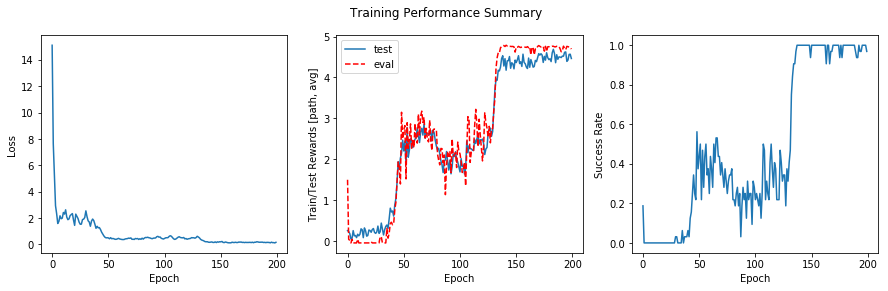

In [135]:
x = np.arange(n_epoch)

plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.plot(x, losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(x, avg_r_train, label="test")
plt.plot(x, avg_r_eval, 'r--', label="eval")
plt.legend()
plt.ylabel('Train/Test Rewards [path, avg]')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(x, success_rates)
plt.ylabel('Success Rate')
plt.xlabel('Epoch')
plt.suptitle('Training Performance Summary')
plt.savefig('figs/job_shop/j%d-w%d_hor' % (njobs, nworkers), dpi=300)

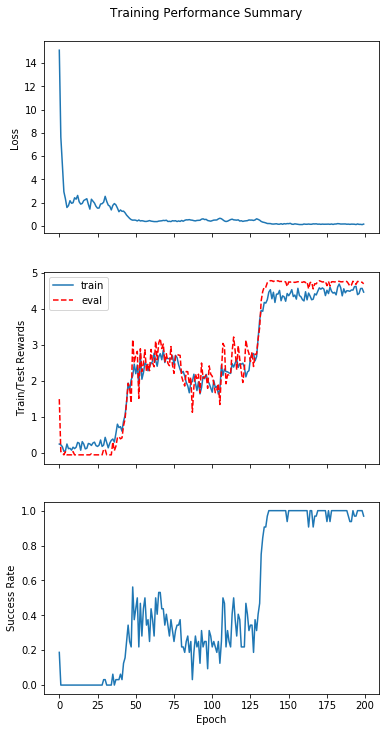

In [136]:
ylabels = ['Loss', 'Train/Test Rewards', 'Success Rate']

fig, axs = plt.subplots(3, 1, figsize=(6, 12))
plt.suptitle('Training Performance Summary', y=.92)
axs[0].plot(x, losses)
axs[1].plot(x, avg_r_train, label="train")
axs[1].plot(x, avg_r_eval, 'r--', label="eval")
axs[1].legend()
axs[2].plot(x, success_rates)

for label, ax in zip(ylabels, axs.flat):
    ax.set(xlabel='Epoch', ylabel=label)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.savefig('figs/job_shop/j%d-w%d_ver' % (njobs, nworkers), dpi=300)